# **Evaluation Notebook**





#**Preparations**


> In this group of cells we will prepare all the variables, code & configurations that we might need while going through all the phases of increamental learning.

** Do not run any code after this without running this group of cells **




## Mount Drive


>First we need to mount the drive so we can retrieve the code and data from our storage in to the notebook.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install Necessary Packages


> We need to install the packages that are needed for this model. Most of the packages are already installed in google colab. We will install the packages which are either not installed or we need some specific version of the package.




In [ ]:
# keras version 2.0.8,
# tensorflow version 1.5 ,
# version mrcnn 0.1 works!
!pip install h5py==2.10.0
for _ in range(2):
 !pip install keras==2.1.0
!pip install -U scikit-image==0.16.2
%tensorflow_version 1.x
# !pip install mrcnn==0.1


     |████████████████████████████████| 2.9 MB 5.3 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 302 kB 5.3 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.7.0 requires keras<2.8,>=2.7.0rc0, but you have keras 2.1.0 which is incompatible.
     |████████████████████████████████| 26.5 MB 1.6 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages

##Import all the necessary Code & set Required Parameters

>We now import all the necessary code and classes that we would need for this model to work. We will also set all the paths that might be needed for loading data from the storage.




In [ ]:
import os

# Root directory of the project
ROOT_DIR='/content/drive/MyDrive/22_01_05Munazza'
MODEL_DIR_WEIGHTS=os.path.join(ROOT_DIR,"Weights")
OUTPUT_DIR=os.path.join(ROOT_DIR,"Outputs")
%cd $ROOT_DIR
import imgaug.augmenters as iaa
import csv
import copy
import matplotlib
import matplotlib.pyplot as plt
import mrcnn.utils as utils
from mrcnn import visualize

##uncomment the following lines if not running on google colab
#import mrcnn.model as modellib
#MODEL_LOG_DIR=ROOT_DIR+"/logs/"

##uncomment the following lines if running on google colab
import mrcnn_colab.model as modellib
MODEL_LOG_DIR="/content/"

from mrcnn.config import Config
import mrcnn.visualize
from mrcnn.model import log
import sys
import random
import math
import re
import time
import numpy as np
import cv2
from os.path import join
import sys
import skimage
from skimage.filters import threshold_mean
from skimage.color import rgb2gray, gray2rgb
import json
from PIL import Image, ImageDraw
from pathlib import Path
import collections
from collections import defaultdict
from pycocotools import mask as MASK
from skimage import measure
from sklearn.metrics import classification_report
from IPython.display import clear_output
from mrcnn.visualize import display_images
import tensorflow as tf
from sklearn.utils import shuffle
%matplotlib inline
# RESULTANTDATASETFOLDER=ROOT_DIR+"/dataset"
# R_Images=RESULTANTDATASETFOLDER+"/images/"
# R_Masks=RESULTANTDATASETFOLDER+"/masks/"



def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
def pltGraph(epochs,history):
  plt.figure(figsize=(21,11))
  plt.subplot(231)
  plt.plot(epochs, history["loss"], label="Train loss")
  plt.plot(epochs, history["val_loss"], label="Valid loss")
  plt.legend()
  plt.subplot(232)
  plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class ce")
  plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class ce")
  plt.legend()
  plt.subplot(233)
  plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
  plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
  plt.legend()
  plt.subplot(234)
  plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class ce")
  plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class ce")
  plt.legend()
  plt.subplot(235)
  plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
  plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
  plt.legend()
  plt.subplot(236)
  plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
  plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
  plt.legend()
  plt.show()
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
from string import ascii_uppercase


#function to calculate IoU
def get_iou(a, b, epsilon=1e-5):
    """
    Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.
    Args:
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero
    Returns:
        (float) The Intersect of Union score.
    """
    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)
    return iou

def gt_pred_lists(gt_class_ids, gt_bboxes, pred_class_ids, pred_bboxes, iou_tresh = 0.5):

    """
        Given a list of ground truth and predicted classes and their boxes,
        this function associates the predicted classes to their gt classes using a given Iou (Iou>= 0.5 for example) and returns
        two normalized lists of len = N containing the gt and predicted classes,
        filling the non-predicted and miss-predicted classes by the background class (index 0).
        Args    :
            gt_class_ids   :    list of gt classes of size N1
            pred_class_ids :    list of predicted classes of size N2
            gt_bboxes      :    list of gt boxes [N1, (x1, y1, x2, y2)]
            pred_bboxes    :    list of pred boxes [N2, (x1, y1, x2, y2)]

        Returns :
            gt             :    list of size N
            pred           :    list of size N
    """

    #dict containing the state of each gt and predicted class (0 : not associated to any other class, 1 : associated to a classe)
    gt_class_ids_ = {'state' : [0*i for i in range(len(gt_class_ids))], "gt_class_ids":list(gt_class_ids)}
    pred_class_ids_ = {'state' : [0*i for i in range(len(pred_class_ids))], "pred_class_ids":list(pred_class_ids)}

    #the two lists to be returned
    pred=[]
    gt=[]

    for i, gt_class in enumerate(gt_class_ids_["gt_class_ids"]):
        for j, pred_class in enumerate(pred_class_ids_['pred_class_ids']):
            #check if the gt object is overlapping with a predicted object
            if get_iou(gt_bboxes[i], pred_bboxes[j])>=iou_tresh:
                #change the state of the gt and predicted class when an overlapping is found
                gt_class_ids_['state'][i] = 1
                pred_class_ids_['state'][j] = 1
                #chack if the overlapping objects are from the same class
                if (gt_class == pred_class):
                    gt.append(gt_class)
                    pred.append(pred_class)
                #if the overlapping objects are not from the same class
                else :
                    gt.append(gt_class)
                    pred.append(pred_class)
    #look for objects that are not predicted (gt objects that dont exists in pred objects)
    for i, gt_class in enumerate(gt_class_ids_["gt_class_ids"]):
        if gt_class_ids_['state'][i] == 0:
            gt.append(gt_class)
            pred.append(0)
    #look for objects that are mispredicted (pred objects that dont exists in gt objects)
    for j, pred_class in enumerate(pred_class_ids_["pred_class_ids"]):
        if pred_class_ids_['state'][j] == 0:
            gt.append(0)
            pred.append(pred_class)
    return gt, pred

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[36,36], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions,
        return the tp, fp and fn
    """

    #data
    if(not columns):
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:max(len(np.unique(y_test)),len(np.unique(predictions)))]]

    y_test = np.array(y_test)
    predictions = np.array(predictions)
    #confusion matrix
    confm = confusion_matrix(y_test, predictions)
    num_classes = len(columns)
    sn.heatmap(confm, annot = True)
    #compute tp fn fp
    fp=[0]*num_classes
    fn=[0]*num_classes
    tp=[0]*num_classes
    tn = [0]*num_classes
    tn[0] = confm[1][1]
    tn[1] = confm[0][0]
    for i in range(confm.shape[0]):
        fp[i]+=np.sum(confm[i])-np.diag(confm)[i]
        fn[i]+=np.sum(np.transpose(confm)[i])-np.diag(confm)[i]
        for j in range(confm.shape[1]):
            if i==j:
                tp[i]+=confm[i][j]
    return tp, fp, fn, tn, confm
# Compute VOC-style Average Precision



def compute_batch_ap(dataset,ids,limit):

    shuffle(ids,random_state=0)
    APs = []
    AllPricisions=[]
    AllRecalls=[]
    AllOverlaps=[]

    counter=0
    #ground-truth and predictions lists for each object
    gt_tot = np.array([])
    pred_tot = np.array([])
    for image_id in image_ids:
        # Load image
        clear_output(wait=True)
        print(counter)

        ErrorFlag=True
        # while ErrorFlag:
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
              modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
          # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        try:
            #compute gt_tot and pred_tot
            gt, pred = gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
            gt_tot = np.append(gt_tot, gt)
            pred_tot = np.append(pred_tot, pred)

            # Compute AP
            AP, precisions, Recalls, overlaps =\
                utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
            ErrorFlag=False
        except:
            # image_id = random.choice(ids)
            # ErrorFlag=True
            continue
        APs.append(AP)
        AllPricisions.append(precisions)
        AllRecalls.append(Recalls)
        AllOverlaps.append(overlaps)
        counter=counter+1
        if counter>=limit:
          break

    return APs,AllPricisions,AllRecalls,AllOverlaps,gt_tot,pred_tot



##Define Configurations.

>We now create a CavityConfig class that will inherit the Config class from MRCNN. It will hold all the configuration that are necessary for designing the architechture of our model for training. Similarly we create class CavityInferenceConfig that inherits CavityTrainingConfig. This class will hold all the configurations that might be needed to create the architechture of model for inference/detections.



In [ ]:
class MappingTrainingConfig(Config):
    """Configuration for training on the box_synthetic dataset.
    Derives from the base Config class and overrides specific values.
    """
    # Give the configuration a recognizable name
    NAME = "MappingTrainingModel"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 for building
    IMAGE_SHAPE = [512, 512, 3]
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 100

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 50
    MINI_MASK_SHAPE=(112, 112)
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    # BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 1000
    def __init__(self):
        super().__init__()

class MappingInferenceConfig(MappingTrainingConfig):
    NAME = "MappingInferenceModel"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE=0.65
    def __init__(self):
        super().__init__()




##Define Dataset.

>We now create a CocoLikeDataset class that will inherit the Utils.Dataset class from MRCNN. It will hold all the methods that are necessary for using our dataset with our model.



In [ ]:

class Dataset(mrcnn.utils.Dataset):

    def load_data(self,FileNames,imagesDir,maskDir):

        # Add classes
        self.add_class("Building", 1, "Building")

        count = 0
        for FileName in FileNames:
          imagePath=os.path.join(imagesDir,FileName)
          maskPath=os.path.join(maskDir,FileName)
          if os.path.exists(maskPath) and os.path.exists(imagePath):
                    self.add_image("Building",
                                   image_id=count,
                                   path=imagePath,
                                   maskpath=maskPath
                                   )
                    count += 1

    def load_mask(self, image_id):
        info = self.image_info[image_id]

        path_mask = info['maskpath']
        image_mask = skimage.io.imread(path_mask)

        im_bw = cv2.cvtColor(image_mask, cv2.COLOR_RGB2GRAY)

        (thresh, im_bw) = cv2.threshold(im_bw, 1, 255, 0)

        contours, hierarchy = cv2.findContours(im_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)



        #image = gray2rgb(image)

        # ret, thresh = cv2.threshold(image_mask, 0, 255, 0)
        # contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)




        class_ids = np.ones(len(contours), np.int32)

        masks = np.zeros((image_mask.shape[0],image_mask.shape[1], len(contours)), dtype=np.bool)

        for i in range(len(contours)):
            img_cont = np.zeros((image_mask.shape[0],image_mask.shape[1],3) , dtype=np.int8)

            cv2.drawContours(img_cont, contours, i, (255,255,255), -1)

            bimask = np.zeros(img_cont.shape[0:2], dtype=np.uint8)

            bimask = img_cont[:,:, 0]

            thresh = threshold_mean(bimask)
            mask = bimask > thresh
            masks[:, :, i]= mask


        return masks, class_ids


##Define Annotation Processor.

>We now create a DatasetProcessor class that will help us manipulate the COCO annotations File. It will hold all the methods that are necessary for manipulating coco Annotation file. We will be using this class to manipulate annotation files during the process of Increamental Learning.



In [ ]:
class DatasetProcessor:
    def __init__(self):
        self.jsonFile={}
        self.annotationFilePath=""
    def getAnnotationsDictByImageId(self):
      annotations ={}
      for annotation in self.jsonFile['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
      return annotations

    def readJsonFile(self, annotation_json):
        #reading all the json data into a cocojson variable
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        # storing it into a class variable so it can be used later
        # we have to keep all the data so that we don't change any format of the data
        self.jsonFile=coco_json
        self.annotationFilePath=annotation_json
        self.updateCurrentMaxId()

    def updateCurrentMaxId(self):
        # set the current max Ids which can be help full for adding images later
        self.maxAnnotationId=-1
        self.maxImageId=-1
        for annotation in self.jsonFile['annotations']:
            id=int(annotation['id'])
            if (id>self.maxAnnotationId):
              self.maxAnnotationId=id
        for image in self.jsonFile['images']:
            image_id = int(image['id'])
            if (image_id>self.maxImageId):
              self.maxImageId=image_id



    def RemoveUnanotatedImages(self):
        # reading all the annotations

        annotations ={}
        for annotation in self.jsonFile['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        seen_images = {}
        #read all the images from json file and append only the image that does not repeat and has an annotation in annotations
        images=[]
        for image in self.jsonFile['images']:
            image_id = image['id']
            if image_id not in seen_images:
                seen_images[image_id] = image
                image_annotations = annotations.get(image_id,None)
                if image_annotations!=None and image_annotations!=[]:
                  images.append(image)

        # replace all the images of the file with the updated list of images
        self.jsonFile['images']=images
    def WriteAnnotationFile(self,savePath):
        directory,fileName=os.path.split(savePath)
        saveLocation=os.path.join(directory,fileName)
        if not os.path.isdir(directory):
          os.makedirs(directory)

        with open(saveLocation, 'w') as outfile:
          json.dump(self.jsonFile, outfile)


    def checkIfImageExists(self,imageFileName):
        # this method checks the existence of the image. if it exist then it returns its id with a True else it return false with none
        for image in self.jsonFile['images']:
            if image['file_name']==imageFileName:
              return True,image
        return False,None
    def addImagesFromDirExceptGivenList(self,dirPath,expnameList):
        #this method will add all the images from dirpath except the given name list
        #this will also return the image with the details about it in json file
        for f in os.listdir(dirPath):
          if f not in expnameList and os.path.isfile(os.path.join(dirPath, f)):
            image=cv2.imread(os.path.join(dirPath, f))
            self.addImage(f,image)



    def RemoveAnnotationsByImageId(self,image_id):
        # this method removes any annotations of an image that might exist by image Id
        annotations=[]
        for annotation in self.jsonFile['annotations']:
            if annotation['image_id']!=image_id:
              annotations.append(annotation)
        self.jsonFile['annotations']=annotations

    def RemoveImageById(self,image_id):
        images=[]
        for image in self.jsonFile['images']:
            if image['id']!=image_id:
              images.append(image)
            else :
              self.RemoveAnnotationsByImageId(image['id'])
        self.jsonFile['images']=images


    def RemoveImageByName(self,name):
        images=[]
        for image in self.jsonFile['images']:
            if image['file_name']!=name:
              images.append(image)
            else :
              self.RemoveAnnotationsByImageId(image['id'])
        self.jsonFile['images']=images

    def removeAllImages(self):
      self.jsonFile['images']=[]

    def removeAllAnnotations(self):
      self.jsonFile['annotations']=[]

    def addImage(self,imageFileName,image):
        # method to add a image to our current json file
        #first we check if image already exist. if it does not we add new image
        # if it does then we empty it annotations

        # check if image exists
        found,im=self.checkIfImageExists(imageFileName)
        if not found:
        # if not found use assign new id and add the image
          self.maxImageId=self.maxImageId+1
          id=self.maxImageId
          im={
             'file_name':imageFileName,
             'id':id,
             'height':image.shape[0],
             'width':image.shape[1]
             }
          self.jsonFile['images'].append(im)
        else :
          # else remove the current annotations for the image
          self.RemoveAnnotationsByImageId(id)
        return im

    def addImageAnnotations(self,r_masks,categoryIds,imageFileName,image):
        # adding this image to annotations file
        im=self.addImage(imageFileName,image)
        # adding annotations of each instance present in this image.
        for i in range(r_masks.shape[2]):
          self.addImageAnnotation(im['id'],r_masks[:,:,i],categoryIds[i])


    def addImageAnnotation(self,image_id,r_mask,categoryId):
         # translating the mask in to polygons
         temp_mask = r_mask.astype(int)
         ground_truth_binary_mask = np.array(temp_mask, dtype=np.uint8)
         fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
         encoded_ground_truth = MASK.encode(fortran_ground_truth_binary_mask)
         ground_truth_area = MASK.area(encoded_ground_truth)
         ground_truth_bounding_box = MASK.toBbox(encoded_ground_truth)
         contours = measure.find_contours(ground_truth_binary_mask, 0.5)
         # adding annotation for this mask in to the annotation file
         self.maxAnnotationId=self.maxAnnotationId+1
         annotation = {
             "segmentation": [],
             "area": int(ground_truth_area.tolist()),
             "iscrowd": 0,
             "image_id": int(image_id),
             "bbox": [int(x) for x in ground_truth_bounding_box.tolist()],
             "category_id": int(categoryId),
             "id": int(self.maxAnnotationId)
         }

            # putting each contour as a segmentation in our annotation for this mask
         for contour in contours:
             contour = np.flip(contour, axis=1)
             segmentation = contour.ravel().tolist()
             annotation["segmentation"].append(segmentation)
         self.jsonFile['annotations'].append(annotation)

    def BreakDataset(self,TrainRatio):
      annotations={}
      for annotation in self.jsonFile['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
      random.shuffle(self.jsonFile['images'])
      devider=int(TrainRatio*len(self.jsonFile['images']))

      trainImages=self.jsonFile['images'][:devider]

      testImages=self.jsonFile['images'][devider:]

      TrainFile=DatasetProcessor()
      TrainFile.jsonFile=self.jsonFile.copy()
      TrainFile.removeAllAnnotations()
      TrainFile.removeAllImages()

      TestFile=DatasetProcessor()
      TestFile.jsonFile=self.jsonFile.copy()
      TestFile.removeAllAnnotations()
      TestFile.removeAllImages()

      for image in trainImages:
           TrainFile.jsonFile['images'].append(image)
           TrainFile.jsonFile['annotations'] = TrainFile.jsonFile['annotations'] + annotations.get(image['id'],[])

      for image in testImages:
           TestFile.jsonFile['images'].append(image)
           TestFile.jsonFile['annotations'] = TestFile.jsonFile['annotations'] + annotations.get(image['id'],[])

      return TrainFile,TestFile

    def CombineCOCOFiles(DatasetProcessorsList):
      """takes a list of datasetProcessor Objects and combines the images and annotations and returns it"""
      """"please make sure that all the files that you are trying to combine have same categories Other wise you will run into errors"""
      for elem in DatasetProcessorsList:
        assert elem.jsonFile['categories']==DatasetProcessorsList[0].jsonFile['categories'] , "all the files should have same categories"

      CombinedFile=DatasetProcessor()
      CombinedFile.jsonFile=DatasetProcessorsList[0].jsonFile.copy()
      CombinedFile.removeAllAnnotations()
      CombinedFile.removeAllImages()
      CombinedFile.updateCurrentMaxId()
      for File in DatasetProcessorsList:
        annotationsDict=File.getAnnotationsDictByImageId()
        for image in File.jsonFile['images']:
          CombinedFile.maxImageId=CombinedFile.maxImageId+1
          ImageAnnotations=annotationsDict.get(image['id'],[])
          image['id']=CombinedFile.maxImageId
          CombinedFile.jsonFile['images'].append(image)
          for annotation in ImageAnnotations:
            CombinedFile.maxAnnotationId=CombinedFile.maxAnnotationId+1
            annotation['image_id']=image['id']
            annotation['id']=CombinedFile.maxAnnotationId
            CombinedFile.jsonFile['annotations'].append(annotation)
      return CombinedFile


##Patching related work

In [ ]:
def makeWindows(image,height,width):
  img=resizeToFit(image,height,width)
  n_x=int(img.shape[1]/width)
  n_y=int(img.shape[0]/height)

  images_dict={}
  for y in range(1,n_y+1):
    for x in range(1,n_x+1):
      images_dict[(x,y)]=img[height*(y-1):height*y,width*(x-1):width*x,:]
  return images_dict, img

# we redifine our visualize instances to match our current requirements

def resize(image, width, height):
        '''
        Resize PIL image keeping ratio and using black background.
        '''
        from PIL import Image
        im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_pil=Image.fromarray(im)
        ratio_w = width / image_pil.width
        ratio_h = height / image_pil.height
        if ratio_w < ratio_h:
            # It must be fixed by width
            resize_width = width
            resize_height = round(ratio_w * image_pil.height)
        else:
            # Fixed by height
            resize_width = round(ratio_h * image_pil.width)
            resize_height = height
        image_resize = image_pil.resize((resize_width, resize_height), Image.ANTIALIAS)
        background = Image.new('RGBA', (width, height), (0, 0, 0, 1))
        offset = (round((width - resize_width) / 2), round((height - resize_height) / 2))
        background.paste(image_resize, offset)
        return np.asarray(background.convert('RGB'))

def resizeToFit(image,width,height):
    originalWidthRatio=math.ceil(image.shape[1]/width)
    originalHeightRatio=math.ceil(image.shape[0]/height)

    img=resize(image,originalWidthRatio*width,originalHeightRatio*height)
    return img
def MergeMasks(masks):
    if masks.shape[2]==1:
        return masks[:,:,0]
    if masks.shape[2]==0:
        return np.zeros((masks.shape[0],masks.shape[1]),dtype=np.bool)

    msk=masks[:,:,0]
    for i in range(1,masks.shape[2]):
        msk=np.logical_or(msk,masks[:,:,i])
    return msk


def processPatches(img,model,path,Patch_height,Patch_width, showPatches=False):
  # imageName=os.path.split(path)[1][:-4]
  # dir=PREDICT_OUT_DIR+"/"+imageName
  # if not os.path.exists(dir):
  #   os.mkdir(dir)
  images,img=makeWindows(img,Patch_height,Patch_width)
  print("image has been devided into "+str(len(images))+" sections")


  total_no_b=0
  outputDict={}
  outputMasksDict={}
  counter=0
  for i,j in images:
    print(str(counter)+" out of "+str(len(images))+" patches done ")
    counter=counter+1
    image=images[(i,j)]
    # Run object detection
    results = model.detect([image])
    # Display results
    r = results[0]
    no_b=len(r['class_ids'])
    total_no_b=total_no_b+no_b

    # a=place_instances(image, r['rois'], r['masks'], r['class_ids'],
    #                         ['BG','Building'], r['scores'],
    #                         title="Number of buildings in this image:"+str(no_b),show=showPatches)
    croppedMask=MergeMasks(r['masks'])

    if showPatches:
        display_instances(image, r['rois'], r['masks'], r['class_ids'], ['BG','Building'], r['scores'], title=str(i)+" "+str(j))
        plt.show()
    # if showPatches:
    #     croppedMaskArr=np.zeros((croppedMask.shape[0],croppedMask.shape[1],1),dtype=np.bool)
    #     croppedMaskArr[:,:,0]=croppedMask
    #     display_instances(image,  np.array([[0,0,image.shape[0],image.shape[1]]]),croppedMaskArr, np.array([1]), ['BG','Building'], np.array([1]), title=str(i)+" "+str(j))
    #     plt.show()
    #save to drive as image
    # savepath=dir+"/"+str(i)+"_"+str(j)+"Detections.jpg"
    # saveImg=cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    # cv2.imwrite(savepath,saveImg)
    # savepath=dir+"/"+str(i)+"_"+str(j)+"Original.jpg"
    # cv2.imwrite(savepath,image)
    # outputDict[(i,j)]=a
    outputMasksDict[(i,j)]=croppedMask

  # combine all patches again
#   outputImg=np.zeros_like(img)
  outputMask=np.zeros((img.shape[0],img.shape[1]),dtype=np.bool)
  # for x,y in outputDict:
  #     outputImg[Patch_height*(y-1):Patch_height*y,Patch_width*(x-1):Patch_width*x,:]=outputDict[(x,y)]
  for x,y in outputMasksDict:
      outputMask[Patch_height*(y-1):Patch_height*y,Patch_width*(x-1):Patch_width*x]=outputMasksDict[(x,y)]

  # #  save output image
  # savepath=dir+"/~ConcatinatedImage.tif"
  # saveImg=cv2.cvtColor(outputImg, cv2.COLOR_BGR2RGB)
  # cv2.imwrite(savepath,saveImg)
  # savepath=dir+"/~OriginalImage.tif"
  # saveImg=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # cv2.imwrite(savepath,saveImg)

  maskArr=np.zeros((outputMask.shape[0],outputMask.shape[1],1),dtype=np.bool)
  maskArr[:,:,0]=outputMask
  return img, maskArr,  total_no_b
def loadMaskFromFile(path,Patch_height,Patch_width):
    mask=cv2.imread(path)
    mask=resizeToFit(mask,Patch_height,Patch_width)
    bnMask=np.zeros((mask.shape[0],mask.shape[1],1),dtype=np.bool)
    bnMask[:,:,0]=mask[:,:,0]>0
    return bnMask
def SaveMaskToFile(path,mask):
    mskImg=(mask[:,:,0]*255).astype(np.uint8)
    mskrgbImg=np.zeros((mskImg.shape[0],mskImg.shape[1],3),dtype=np.uint8)
    mskrgbImg[:,:,0]=mskImg
    mskrgbImg[:,:,1]=mskImg
    mskrgbImg[:,:,2]=mskImg
    cv2.imwrite(path,mskrgbImg)

def RemoveLowSizedInstances(msk, minArea):
    mskImg=(msk[:,:,0]*255).astype(np.uint8)
    contours = cv2.findContours(mskImg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    mask = np.zeros_like(mskImg)

    for cnt in contours:
        if cv2.contourArea(cnt)>minArea:
            cv2.fillPoly(mask, pts = [cnt], color =(255,))
    maskarr=np.zeros_like(msk)
    maskarr[:,:,0]=mask>0
    return maskarr

###Define Visualizer

In [ ]:
import colorsys
from skimage.measure import find_contours

from matplotlib import patches,  lines
from matplotlib.patches import Polygon
def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        pass
        # plt.show()
def display_top_masks(image, mask, class_ids, class_names, limit=4):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")



#Infer


In [ ]:
config = MappingInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.65
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 10.0, 'rpn_bbox_loss': 10.0, 'mrcnn_class_loss': 10.0, 'mrcnn_bbox_loss': 10.0, 'mrcnn_mask_loss': 10.0}
MASK_POOL_SIZE                 14
MASK_SHAPE       

In [ ]:
model = modellib.MaskRCNN(mode="inference", config=config,
                          model_dir=MODEL_LOG_DIR)

In [ ]:
path=MODEL_DIR_WEIGHTS+'/BestModelWeights1.h5'
model.load_weights(path, by_name=True)


In [ ]:
imgpath="/content/drive/MyDrive/22_01_05Munazza/AlignedData/images/060102w.tif"
mskpath="/content/drive/MyDrive/22_01_05Munazza/AlignedData/masks/060102w.tif"
_, imgName=os.path.split(imgpath)
Patch_height=300
Patch_width=300
img=cv2.imread(imgpath)
OriginalMask=loadMaskFromFile(mskpath,Patch_height,Patch_width)
img,PredictedMask,no_b1=processPatches(img,model,path,Patch_height,Patch_width,showPatches=False)






image has been devided into 132 sections
0 out of 132 patches done 
1 out of 132 patches done 
2 out of 132 patches done 
3 out of 132 patches done 
4 out of 132 patches done 
5 out of 132 patches done 
6 out of 132 patches done 
7 out of 132 patches done 
8 out of 132 patches done 
9 out of 132 patches done 
10 out of 132 patches done 
11 out of 132 patches done 
12 out of 132 patches done 
13 out of 132 patches done 
14 out of 132 patches done 
15 out of 132 patches done 
16 out of 132 patches done 
17 out of 132 patches done 
18 out of 132 patches done 
19 out of 132 patches done 
20 out of 132 patches done 
21 out of 132 patches done 
22 out of 132 patches done 
23 out of 132 patches done 
24 out of 132 patches done 
25 out of 132 patches done 
26 out of 132 patches done 
27 out of 132 patches done 
28 out of 132 patches done 
29 out of 132 patches done 
30 out of 132 patches done 
31 out of 132 patches done 
32 out of 132 patches done 
33 out of 132 patches done 
34 out of 132 pat

In [ ]:
imgOutputDir=os.path.join(OUTPUT_DIR,imgName[:-4])
print(imgOutputDir)
if not os.path.exists(imgOutputDir):
    os.mkdir(imgOutputDir)

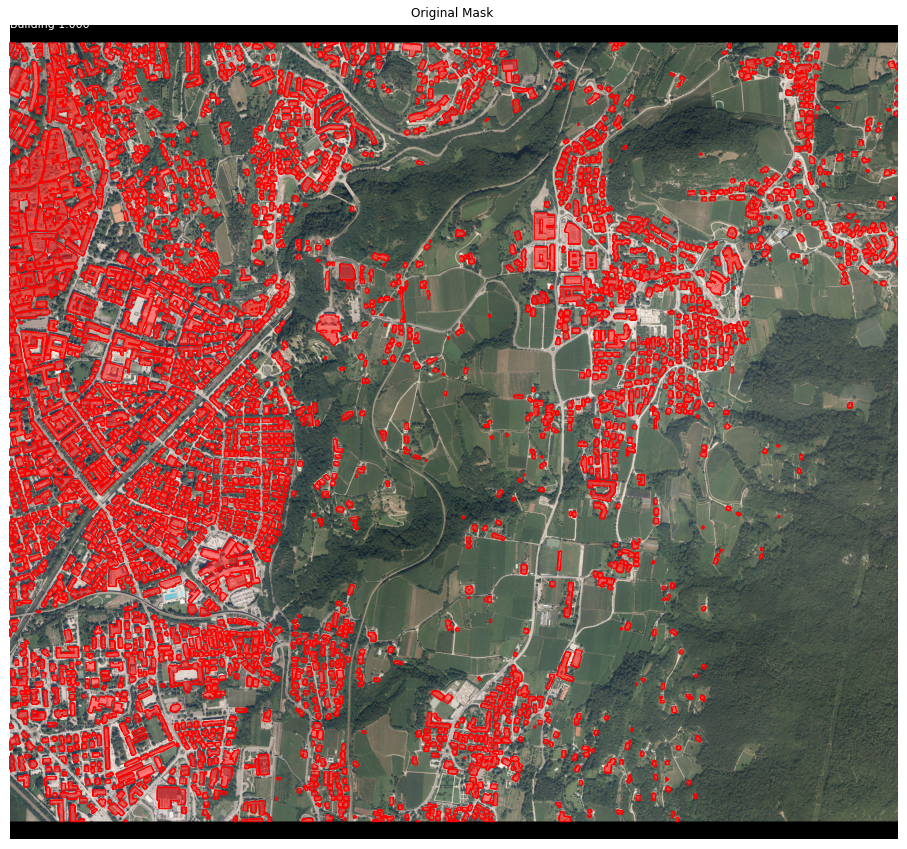

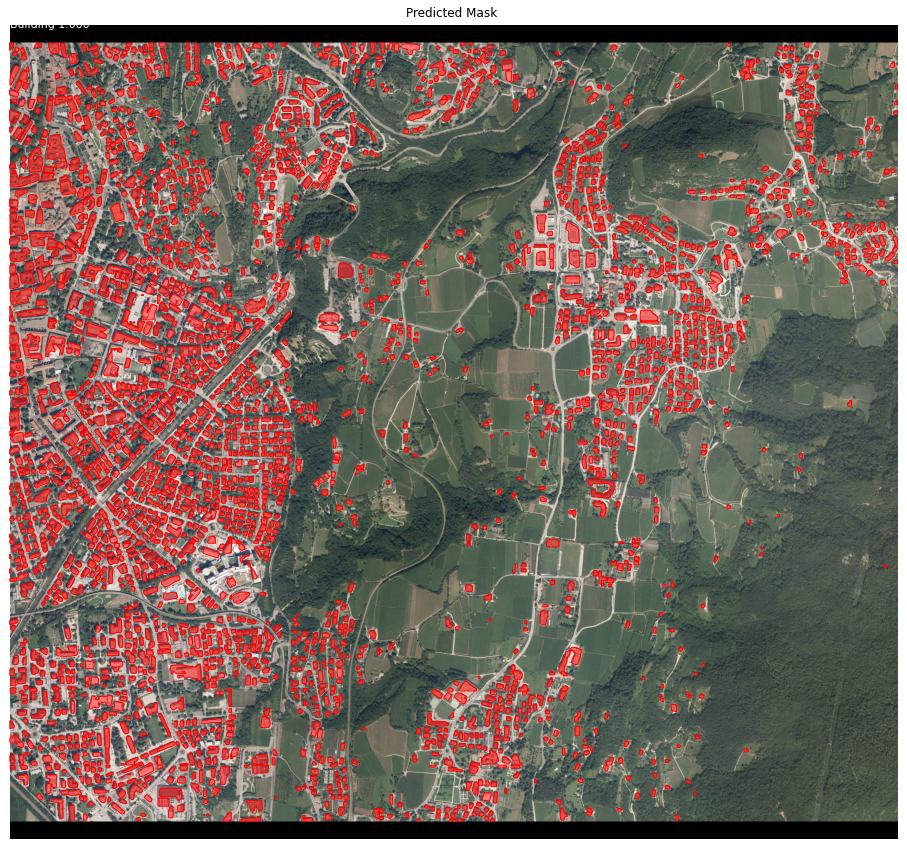

In [ ]:

display_instances(img, np.array([[0,0,img.shape[0],img.shape[1]]]),OriginalMask, np.array([1]),
                            ['BG','Building'], np.array([1]),
                            title="Original Mask ",show_mask=True,show_bbox=False)
SaveMaskToFile(os.path.join(imgOutputDir,"OriginalMask.tif"),OriginalMask)
plt.savefig(os.path.join(imgOutputDir,"OriginalMaskPlt.tif"),bbox_inches='tight')
plt.show()

display_instances(img, np.array([[0,0,img.shape[0],img.shape[1]]]),PredictedMask, np.array([1]),
                            ['BG','Building'], np.array([1]),
                            title="Predicted Mask ",show_mask=True,show_bbox=False)

SaveMaskToFile(os.path.join(imgOutputDir,"PredictedMask.tif"),PredictedMask)
plt.savefig(os.path.join(imgOutputDir,"PredictedMaskPlt.tif"),bbox_inches='tight')
plt.show()

Compare Both masks and find which new buildings have been dicovered by the model that were not present in original mask.

In [ ]:
newMask=((PredictedMask*255)-(OriginalMask*255))>0
newMask=RemoveLowSizedInstances(newMask, 300)


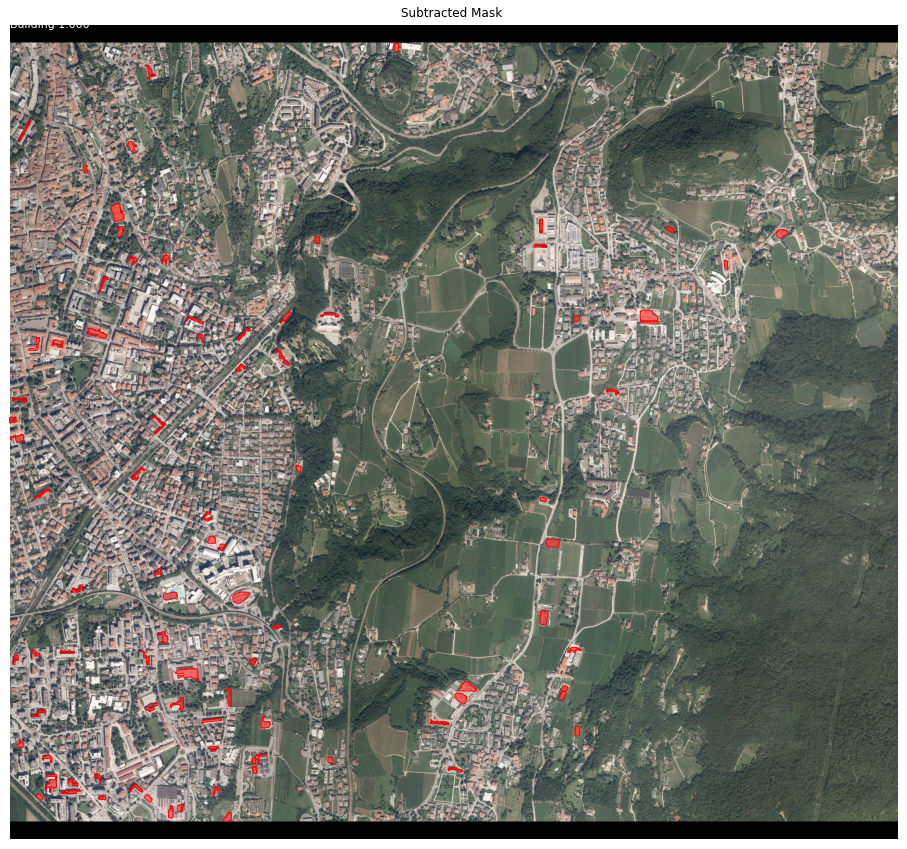

In [ ]:
display_instances(img, np.array([[0,0,img.shape[0],img.shape[1]]]),newMask, np.array([1]),
                            ['BG','Building'], np.array([1]),
                            title="Subtracted Mask ",show_mask=True,show_bbox=False)

SaveMaskToFile(os.path.join(imgOutputDir,"SubtractedMask.tif"),newMask)
plt.savefig(os.path.join(imgOutputDir,"SubtractedMaskPlt.tif"),bbox_inches='tight')
plt.show()